# detectron2 for まちカドまぞく ～評価編～

<img src="https://user-images.githubusercontent.com/33882378/79189949-02f72b80-7e5e-11ea-81e4-cdc58a3d33c9.jpg">

detectron2 で独自データセット学習したモデルの AP, mAP を評価してみる。

> 参考にさせていただいたホームページ（感謝です）<br/>
> https://qiita.com/tmtakashi_dist/items/863e1781b5252e453b47<br/>
> https://qiita.com/panchokyutech/items/2c972ede2bc883597a87<br/>
> https://qiita.com/mdo4nt6n/items/08e11426e2fac8433fed<br/>

In [1]:
import os
import numpy as np
import pandas as pd
import json
import cv2
import random
import matplotlib.pyplot as plt

---
## VoTT Export からの読み込み

In [2]:
# VoTT のエクスポートファイルや、画像が格納されているディレクトリ
BASE_DIRECTORY = './vott-json-export/'
# VoTT のエクスポートファイル名
EXPORT_FILENAME = 'Machikado-export.json'
# 訓練データに使用する割合
TRAIN_RATIO = 0.8
# 乱数シード
RANDOM_STATE = 0  # 訓練と同じにしておかないとズレちゃうよ！

In [3]:
from detectron2.data import DatasetCatalog, MetadataCatalog
from machikado_util.Machikado_vott import get_cat_names, get_cat_color, get_machikado_dicts

# vott の読み込み関係は py ファイルにした
CAT_NAME2ID, CAT_ID2NAME = get_cat_names(os.path.join(BASE_DIRECTORY, EXPORT_FILENAME))
dataset_dicts = get_machikado_dicts(os.path.join(BASE_DIRECTORY, EXPORT_FILENAME), BASE_DIRECTORY, CAT_NAME2ID)

# VoTT のカテゴリの色も抽出する
CAT_IDS, CAT_COLORS = get_cat_color(os.path.join(BASE_DIRECTORY, EXPORT_FILENAME))
CAT_IDS, CAT_COLORS

# 日本語表示を試す(CAT_ID2NAME と順番を一致させること！)
CAT_NAME_JP = ['シャミ子', 'ごせん像', 'リリス', 'もも', 'みかん', 'その他']
    
# 訓練用、テスト用に分ける
random.seed(RANDOM_STATE)
random.shuffle(dataset_dicts)

split_idx = int(len(dataset_dicts) * TRAIN_RATIO) + 1

# 登録
DatasetCatalog.clear()
DatasetCatalog.register('train', lambda : dataset_dicts[:split_idx])
DatasetCatalog.register('test', lambda : dataset_dicts[split_idx:])

# 日本語名はこっち
MetadataCatalog.get('train').set(thing_classes=CAT_NAME_JP)
MetadataCatalog.get('test').set(thing_classes=CAT_NAME_JP)

# VoTT のカテゴリ名はこっち
# MetadataCatalog.get('train').set(thing_classes=list(CAT_NAME2ID.keys()))
# MetadataCatalog.get('test').set(thing_classes=list(CAT_NAME2ID.keys()))

警告: name: 59.jpg - 画像サイズが不一致であるためスキップ image_size:(268, 201), ./vott-json-export/Machikado-export.json: (600, 600)


Metadata(name='test', thing_classes=['シャミ子', 'ごせん像', 'リリス', 'もも', 'みかん', 'その他'])

---
## 評価

* AP、mAP を計算したいと思いますが、ちょっと自信がないので説明はしません。
* コードは ./machikado_util/calc_ap.py にありますので、興味がお有りでしたらご覧下さい。

In [4]:
from detectron2.config import get_cfg

cfg = get_cfg()
cfg.OUTPUT_DIR = './output'

# cfg.merge_from_file("../configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml") # ここの位置は ipynb ファイルの層泰一なので注意
# cfg.SOLVER.IMS_PER_BATCH = 2
# cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, 'model_final.pth')

cfg.merge_from_file('../configs/COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml')
cfg.SOLVER.IMS_PER_BATCH = 1 # GTX2070 ではこれが限界
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, 'model_final.pth')

cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(CAT_ID2NAME)  # machikado は6

cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.6   # set the testing threshold for this model

In [5]:
from detectron2.engine import DefaultPredictor
from machikado_util.calc_ap import append_masks, get_true_datas, predict_datas, make_info_dict

# データセットはテストを使用します
catalog_name='test'
# データセットにマスクデータを追加する
append_masks(dataset_dicts)

# 推論器を用意する
predictor = DefaultPredictor(cfg)

# 教師データから評価に必要な情報を取得する
true_dicts = get_true_datas(catalog_name=catalog_name)
# データセットを一度に推論して結果を取得する
pred_dicts = predict_datas(predictor, catalog_name=catalog_name, verbose=False)
# precision, recall を計算する
df_dict = make_info_dict(true_dicts=true_dicts, pred_dicts=pred_dicts, classes=list(CAT_ID2NAME.keys()), th=0.5)

### PR(Precision-Recall)曲線

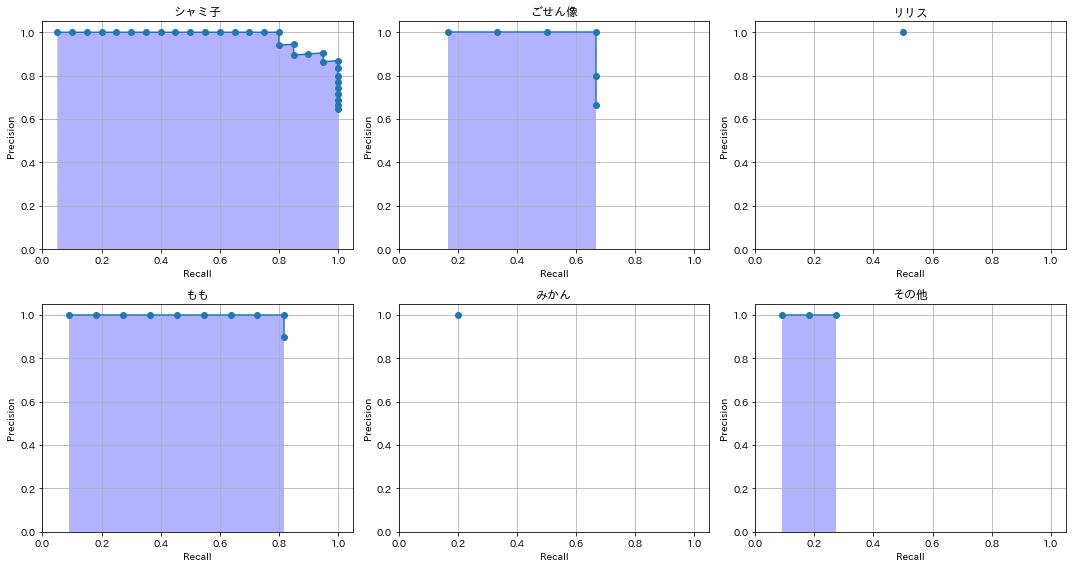

In [6]:
# プロット
plt.figure(figsize=(15, 8))

for i, _cls in enumerate(df_dict.keys()):
    df = df_dict[_cls]
    
    ax = plt.subplot(2, 3, i + 1)
    ax.plot(df['rec'], df['pre'], '-o')
    ax.fill_between(df['rec'], df['pre'], facecolor='b', alpha=0.3)
    ax.set_xlim([0, 1.05])
    ax.set_ylim([0, 1.05])
    ax.grid(True)
    ax.set_title(CAT_NAME_JP[_cls])
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    
plt.tight_layout()
plt.show()

シャミ子がすごいです（笑）。次いで、モモ、ごせん像という感じです。これは、データ数の順番ですよねぇ・・・

> ```
[04/13 23:04:09 d2.data.build]: Removed 0 images with no usable annotations. 92 images left.
[04/13 23:04:09 d2.data.build]: Distribution of instances among all 6 categories:
|  category  | #instances   |  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|:----------:|:-------------|
|  Shamiko   | 70           |  Gosenzo   | 28           |   Lilith   | 12           |
|    Momo    | 41           |   Mikan    | 15           |    Mob     | 12           |
|            |              |            |              |            |              |
|   total    | 178          |            |              |            |              |
```

### AP, mAP の計算

* mAP は期待できませんが、計算してみます。
* AP は、上記チャートのハッチ部分の面積となります。方法は色々ありますが、今回はデータ数が少ないので普通に計算しました。
* mAP は、全クラスの平均となります。
* 今回はしきい値 0.5 です。

In [7]:
def calc_AP(df_dict, cat_names):
    """
    AP を計算する
    """
    AP = []

    for _cls in df_dict.keys():
        df = df_dict[_cls]
        rec, pre = df['rec'].values, df['pre'].values

        # 1つしかない場合は 0
        if len(rec) == 1:
            AP.append(0)
            continue

        # 台形として面積を求めます
        S = 0
        for i in range(len(rec) - 1):
            h = rec[i + 1] - rec[i]
            p1, p2 = pre[i], pre[i + 1]

            S += (p1 + p2) * h / 2

        AP.append(S)
        
    df = pd.DataFrame(AP + [np.mean(AP)], columns=['AP'], index=(CAT_NAME_JP + ['mAP']))
        
    return df

In [8]:
calc_AP(df_dict, cat_names=CAT_NAME_JP)

,AP
シャミ子,0.930458
ごせん像,0.500000
リリス,0.000000
もも,0.727273
みかん,0.000000
その他,0.181818
mAP,0.389925


というか、上位以外が足をひっぱているのがよくわかりますね。

データ数は正義です・・・